<a href="https://colab.research.google.com/github/wgilliland/EBSP_GAN/blob/main/matinfo_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from PIL import Image as im
from PIL import ImageOps
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import ndimage

import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data_utils
from torch.utils.data import Dataset

from google.colab import drive
drive.mount('/content/drive')


from IPython.display import display, clear_output

%matplotlib inline

Mounted at /content/drive


In [ ]:
def open_pattern(patternsdir, patternsname, x, y, ext='.jpg'):
    filename = patternsname+'_x'+str(int(round(x*100, -1)))+'y'+str(int(round(y*100, -1)))+ext
    patternfile = os.path.join(patternsdir, filename)
    pattern = im.open(patternfile)
    gray_pattern = ImageOps.grayscale(pattern)
    pattern_array = np.array(gray_pattern)
    image = gray_pattern.resize((64,64))
    pattern_downsampled = np.array(image)
#     plt.imshow(pattern)
#     plt.show()
    return pattern_array, image, pattern_downsampled


def white_edges(pattern, radius):
    dim, rows, cols = pattern.shape
    new_image = np.array(pattern)
    for kk in range(dim):
        for ii in range(rows):
            for jj in range(cols):
                r2 = (ii - radius/2)**2 + (jj - radius/2)**2
                if r2 > (radius/2)**2:
                    new_image[0, ii, jj] = 255
    return new_image



def over_ex_spot(pattern, min_dim, max_dim):
    new_image = np.array(pattern)
    r = np.random.randint(min_dim, max_dim)
    low = r
    high = 64 - r
    x_c = np.random.randint(low, high)
    y_c = np.random.randint(low, high)
    x_min = x_c - r
    x_max = x_c + r
    y_min = y_c - r
    y_max = y_c + r
    for ii in range(x_min, x_max):
        for jj in range(y_min, y_max):
            new_image[0, jj, ii] = 255
    return new_image


def read_grains_file(filename, patternsdir, patternsname, ext='.jpg'):
    with open(filename) as f:
        lines = f.readlines()
        lines_keep = []
        phi1 = []
        PHI = []
        phi2 = []
        x = []
        y = []
        iq = []
        ci = []
        fit = []
        grain_id = []
        edge = []
        pattern = []
        pattern_downsampled = []
        pattern_white_edges = []
        fake_patterns = []
        images = []
        print('Reading data:')
        for line in tqdm(lines):
            if line[0] != '#':
                temp_line = line.split(' ')
                while '' in temp_line:
                    temp_line.remove('')
                phi1.append(float(temp_line[0]))
                PHI.append(float(temp_line[1]))
                phi2.append(float(temp_line[2]))
                x.append(float(temp_line[3]))
                y.append(float(temp_line[4]))
                
                x_temp = (float(temp_line[3]))
                y_temp = (float(temp_line[4]))
                
                iq.append(float(temp_line[5]))
                ci.append(float(temp_line[6]))
                fit.append(float(temp_line[7]))
                grain_id.append(int(temp_line[8]))
                edge.append(int(temp_line[9]))
                image_array, image, pattern_down = open_pattern(patternsdir, patternsname, x_temp, y_temp, ext=ext)
                pattern_down_to_app = np.reshape(pattern_down, (1, 64, 64))
                pat_down_white_to_app = white_edges(pattern_down_to_app, 64)
                fake = over_ex_spot(pat_down_white_to_app, 5, 20)
                
                pattern.append(image_array)
                pattern_downsampled.append(pattern_down_to_app)
                pattern_white_edges.append(pat_down_white_to_app)
                fake_patterns.append(fake)
                images.append(image)
                
    grains_df = pd.DataFrame(
    {
        'phi1':phi1,
        'PHI':PHI,
        'phi2':phi2,
        'x':x,
        'y':y,
        'iq':iq,
        'ci':ci,
        'fit':fit,
        'grain_id':grain_id,
        'edge':edge,
        'pattern':pattern,
        'pattern_downsampled':pattern_downsampled,
        'pattern_down_white_edge':pattern_white_edges,
        'pattern_fake':fake_patterns,
        'image':image,
    })
                
    return grains_df

In [ ]:
# Block if data is note already saved as hdf5 file
PATH = 'drive/MyDrive'
datadir = os.path.join(PATH, 'DataSample_Steel-master')
for filename in os.listdir(datadir):
    if '.' not in filename:
        patternsname = filename
        patternsdir = os.path.join(datadir, filename)
    elif '.txt' in filename:
        grainsfile = os.path.join(datadir, filename)
        
df = read_grains_file(grainsfile, patternsdir, patternsname)
df.to_hdf(os.path.join(PATH, 'data.h5'), key='df')

Reading data:


100%|██████████| 914/914 [03:40<00:00,  4.14it/s]


In [ ]:
# Use this if hdf5 file is available
PATH = 'drive/MyDrive'
df = pd.read_hdf(os.path.join(PATH, 'data.h5'))

**Class for pytorch dataset**

In [ ]:
class EBSDDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_data = torch.Tensor(df.iloc[index]['pattern_down_white_edge']/255)
        np_context = np.zeros(4)
        np_context[0] = df.iloc[index]['phi1']
        np_context[1] = df.iloc[index]['PHI']
        np_context[2] = df.iloc[index]['phi2']
        np_context[3] = df.iloc[index]['iq']
        context = torch.Tensor(np_context)
        return (image_data, context)

**WGAN with gradient penelty**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

  
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

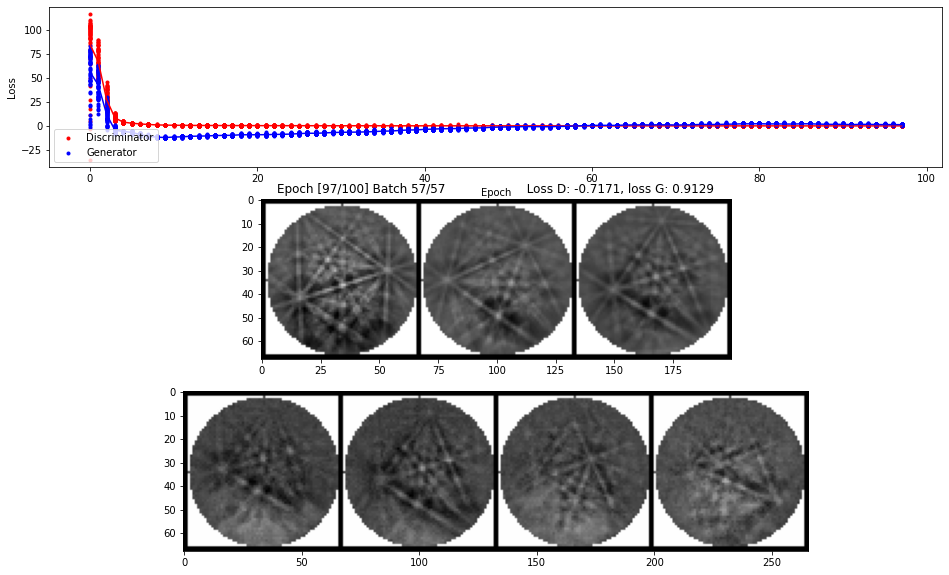

In [ ]:
# Hyperparameters etc.
to_pil = transforms.ToPILImage()

df.groupby('grain_id').size()
df2 = df.groupby('grain_id').get_group(4)
dataset = EBSDDataset(df)

device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

# transforms = transforms.Compose(
#     [
#         transforms.Resize(IMAGE_SIZE),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
#     ]
# )

# dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# comment mnist above and uncomment below for training on CelebA
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = data_utils.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()

fig, ax= plt.subplots(3,1,figsize=(16,10))
# ax = fig.add_subplot(1, 1, 1) 
lossD_plot = []
lossG_plot = []
lossD_means = []
lossG_means = []
epochs = []
epoch_means = []

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    lossD_batch = []
    lossG_batch = []
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        # if batch_idx % 100 == 0 and batch_idx > 0:
            # print(
                # f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                #   Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            # )
        epochs.append(epoch)
        lossD_plot.append(-loss_critic.item())
        lossG_plot.append(loss_gen.item())
        lossD_batch.append(-loss_critic.item())
        lossG_batch.append(loss_gen.item())
        if batch_idx  == len(loader)-1:
            epoch_means.append(epoch)
            lossD_means.append(np.mean(lossD_batch))
            lossG_means.append(np.mean(lossG_batch))
            # epochs.append(epoch)
            # lossD_plot.append(-loss_critic.item())
            # lossG_plot.append(loss_gen.item())
            ax[0].set_xlim(0, epoch)
            ax[0].cla()
            ax[0].scatter(epochs, lossD_plot, marker='.', color='red', label='Discriminator')
            ax[0].plot(epoch_means, lossD_means, color='red')
            ax[0].scatter(epochs, lossG_plot, marker='.', color='blue', label='Generator')
            ax[0].plot(epoch_means, lossG_means, color='blue')
            ax[0].legend(loc='lower left')
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('Loss')
            # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            # ax.grid(linestyle=':', alpha=0.25)
            display(fig)
            clear_output(wait=True)
            plt.pause(0.5)

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:4], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:4], normalize=True)

                img_real = to_pil(img_grid_real)
                img_fake = to_pil(img_grid_fake)
                # fig, ax = plt.subplots(2,1,figsize=(16,6))
                ax[1].set_title(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx+1}/{len(loader)} \
                    Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
                  )
                ax[1].imshow(img_real)
                ax[2].imshow(img_fake)
                # plt.show()
                display(fig)
                clear_output(wait=True)
                plt.pause(0.5)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img+1, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.y_linear = nn.Linear(4, features_d*features_d)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, y):
        y_channel = self.y_linear(y).reshape(64,1,64,64)
        xy = torch.concat([x, y_channel],1)
        return self.disc(xy)



class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+4, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, y):
        y_channel = y.unsqueeze(2).unsqueeze(3)
        xy = torch.concat([x, y_channel],1)
        return self.net(xy)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def gradient_penalty(critic, y, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, y)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

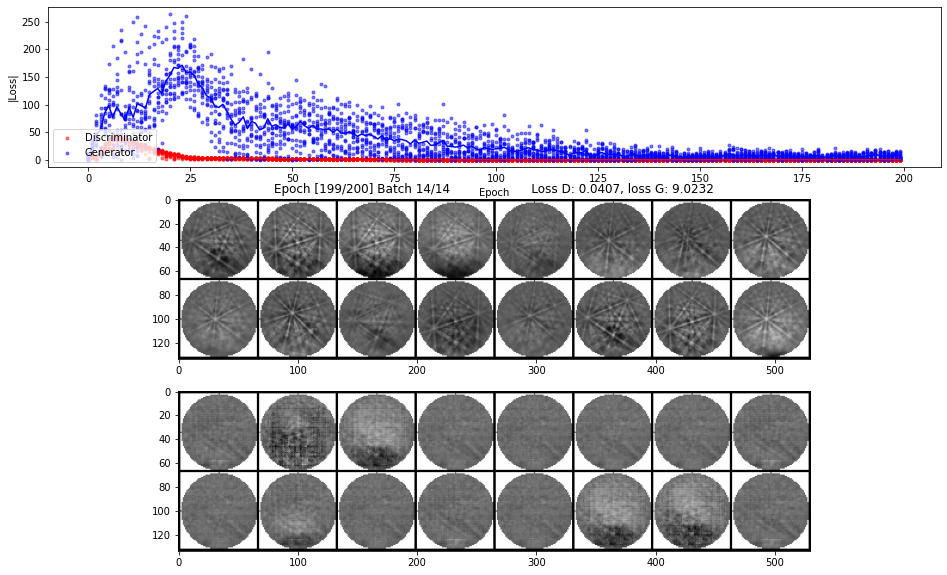

In [ ]:
# Hyperparameters etc.
to_pil = transforms.ToPILImage()

df.groupby('grain_id').size()
df2 = df.groupby('grain_id').get_group(4)
dataset = EBSDDataset(df.iloc[0:896])

device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 200
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

# transforms = transforms.Compose(
#     [
#         transforms.Resize(IMAGE_SIZE),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
#     ]
# )

# dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# comment mnist above and uncomment below for training on CelebA
#dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = data_utils.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(64, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()

fig, ax= plt.subplots(3,1,figsize=(16,10))
# ax = fig.add_subplot(1, 1, 1) 
lossD_plot = []
lossG_plot = []
lossD_means = []
lossG_means = []
epochs = []
epoch_means = []

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    lossD_batch = []
    lossG_batch = []
    for batch_idx, (real, y) in enumerate(loader):
        # print(batch_idx)
        real = real.to(device)
        y = y.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, y)
            critic_real = critic(real, y).reshape(-1)
            critic_fake = critic(fake, y).reshape(-1)
            gp = gradient_penalty(critic, y, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake,y).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        # if batch_idx % 100 == 0 and batch_idx > 0:
            # print(
                # f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                #   Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            # )
        epochs.append(epoch)
        lossD_plot.append(abs(loss_critic.item()))
        lossG_plot.append(abs(loss_gen.item()))
        lossD_batch.append(abs(loss_critic.item()))
        lossG_batch.append(abs(loss_gen.item()))
        if batch_idx  == len(loader)-1:
            epoch_means.append(epoch)
            lossD_means.append(np.mean(lossD_batch))
            lossG_means.append(np.mean(lossG_batch))
            # epochs.append(epoch)
            # lossD_plot.append(-loss_critic.item())
            # lossG_plot.append(loss_gen.item())
            ax[0].set_xlim(0, epoch)
            ax[0].cla()
            ax[0].scatter(
                epochs, 
                lossD_plot, 
                marker='.', 
                color='red', 
                alpha=0.5,
                label='Discriminator'
                )
            ax[0].plot(epoch_means, lossD_means, color='red')
            ax[0].scatter(
                epochs, 
                lossG_plot, 
                marker='.', 
                color='blue',
                alpha=0.5, 
                label='Generator'
                )
            ax[0].plot(epoch_means, lossG_means, color='blue')
            ax[0].legend(loc='lower left')
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('|Loss|')
            # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            # ax.grid(linestyle=':', alpha=0.25)
            display(fig)
            clear_output(wait=True)
            plt.pause(0.5)

            with torch.no_grad():
                fake = gen(fixed_noise,y)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:16], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)

                img_real = to_pil(img_grid_real)
                img_fake = to_pil(img_grid_fake)
                # fig, ax = plt.subplots(2,1,figsize=(16,6))
                ax[1].set_title(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx+1}/{len(loader)} \
                    Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
                  )
                ax[1].imshow(img_real)
                ax[2].imshow(img_fake)
                # plt.show()
                display(fig)
                clear_output(wait=True)
                plt.pause(0.5)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img+1, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )
        self.y_linear = nn.Linear(4, features_d*features_d)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, y):
        y_channel = self.y_linear(y).reshape(16,1,64,64)
        xy = torch.concat([x, y_channel],1)
        return self.disc(xy)



class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+4, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, y):
        y_channel = y.unsqueeze(2).unsqueeze(3)
        xy = torch.concat([x, y_channel],1)
        return self.net(xy)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def gradient_penalty(critic, y, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, y)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

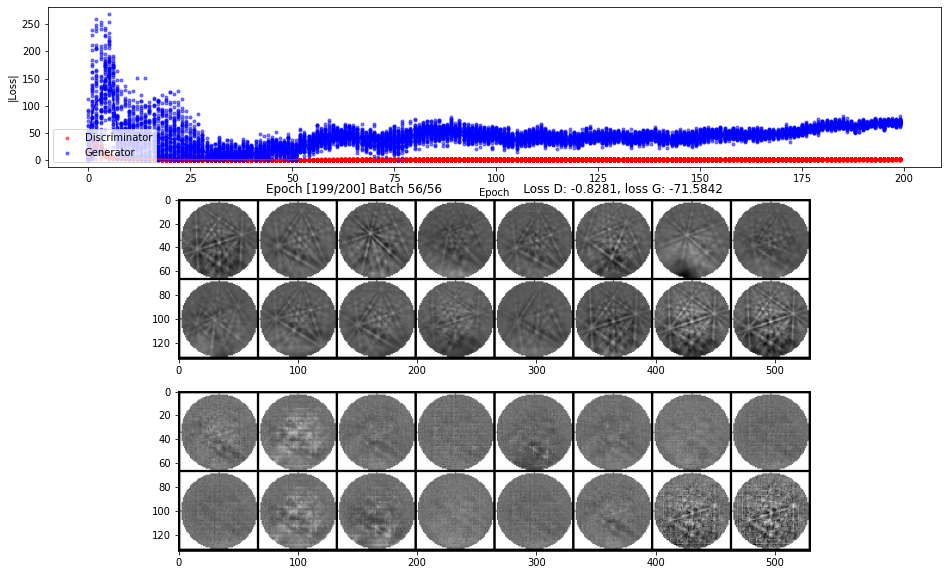

In [ ]:
# Hyperparameters etc.
to_pil = transforms.ToPILImage()

df.groupby('grain_id').size()
df2 = df.groupby('grain_id').get_group(4)
dataset = EBSDDataset(df.iloc[0:896])

device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 200
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 5


loader = data_utils.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(16, Z_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()

fig, ax= plt.subplots(3,1,figsize=(16,10))
# ax = fig.add_subplot(1, 1, 1) 
lossD_plot = []
lossG_plot = []
lossD_means = []
lossG_means = []
epochs = []
epoch_means = []

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    lossD_batch = []
    lossG_batch = []
    for batch_idx, (real, y) in enumerate(loader):
        # print(batch_idx)
        real = real.to(device)
        y = y.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, y)
            critic_real = critic(real, y).reshape(-1)
            critic_fake = critic(fake, y).reshape(-1)
            gp = gradient_penalty(critic, y, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake,y).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        # if batch_idx % 100 == 0 and batch_idx > 0:
            # print(
                # f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                #   Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            # )
        epochs.append(epoch)
        lossD_plot.append(abs(loss_critic.item()))
        lossG_plot.append(abs(loss_gen.item()))
        lossD_batch.append(abs(loss_critic.item()))
        lossG_batch.append(abs(loss_gen.item()))
        if batch_idx  == len(loader)-1:
            epoch_means.append(epoch)
            lossD_means.append(np.mean(lossD_batch))
            lossG_means.append(np.mean(lossG_batch))
            # epochs.append(epoch)
            # lossD_plot.append(-loss_critic.item())
            # lossG_plot.append(loss_gen.item())
            ax[0].set_xlim(0, epoch)
            ax[0].cla()
            ax[0].scatter(
                epochs, 
                lossD_plot, 
                marker='.', 
                color='red', 
                alpha=0.5,
                label='Discriminator'
                )
            ax[0].plot(epoch_means, lossD_means, color='red')
            ax[0].scatter(
                epochs, 
                lossG_plot, 
                marker='.', 
                color='blue',
                alpha=0.5, 
                label='Generator'
                )
            ax[0].plot(epoch_means, lossG_means, color='blue')
            ax[0].legend(loc='lower left')
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('|Loss|')
            # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            # ax.grid(linestyle=':', alpha=0.25)
            display(fig)
            clear_output(wait=True)
            plt.pause(0.5)

            with torch.no_grad():
                fake = gen(fixed_noise,y)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:16], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:16], normalize=True)

                img_real = to_pil(img_grid_real)
                img_fake = to_pil(img_grid_fake)
                # fig, ax = plt.subplots(2,1,figsize=(16,6))
                ax[1].set_title(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx+1}/{len(loader)} \
                    Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
                  )
                ax[1].imshow(img_real)
                ax[2].imshow(img_fake)
                # plt.show()
                display(fig)
                clear_output(wait=True)
                plt.pause(0.5)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1